# DeGiro analyser for stocks and ETFs
This notebook generates plots that display (1) monthly and (2) cumulative purchasing of assets, and (3) the profit/loss compared to the current asset price.

The following nomenclature is used for ETFs and stocks
- Quantity: the amount of a particular asset
- Value: the value of an asset in a defined currency
- Total: Quantity * Value

In [1]:
# load libraries
from src.functions import get_quantity_and_value_from_description
from src.functions import read_account_overview
from src.functions import get_start_datetime
from src.functions import get_historical_stock_price
from src.plots import plot_dividend, plot_transactions
from src.plots import plot_cumulative_transaction_value_and_current_value
from datetime import datetime, timedelta

In [2]:
# Load account xls into dataframe, calculate reduced (YYYY-MM)
df_account = read_account_overview('Account.csv')

# Define (part) of product name and ticker symbols as dictionary. 
# Note: Compared to online overview, product names in excel/csv exports are i) capped and ii) capitalized.
products = {
    'Vanguard FTSE All-World UCITS ETF': 'VWRL.AS',
}

# Define current datetime as YYYY-MM-DD
current_datetime = datetime.now().strftime('%Y-%m-%d')

/Users/jurnheinen/Python/degiro_analyser/src/plots.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(date, rotation=45, ha='right')


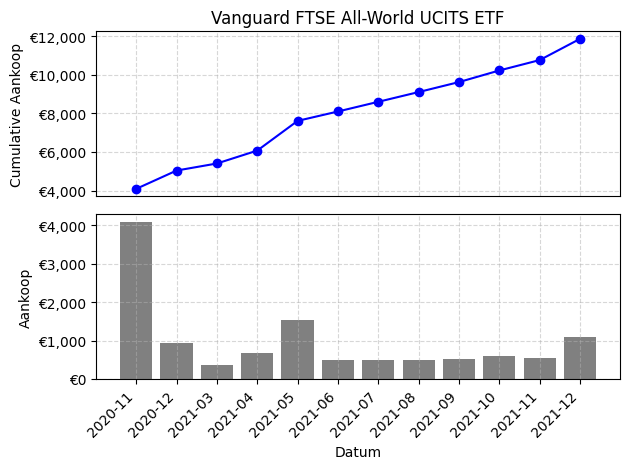

/Users/jurnheinen/Python/degiro_analyser/src/plots.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(date, rotation=45, ha='right')


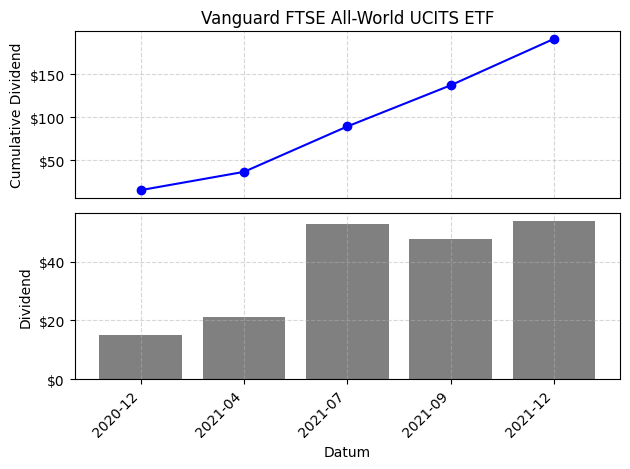

/Users/jurnheinen/Python/degiro_analyser/src/plots.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(date, rotation=45, ha='right')


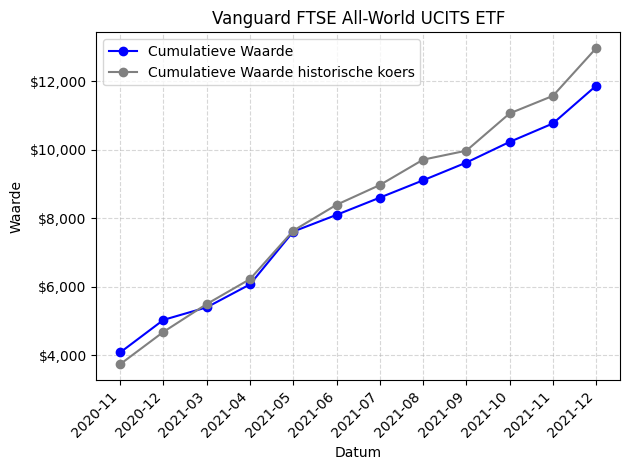

In [3]:
for product, ticker in products.items():
    # Get only records of pre-defined product
    df_product = df_account[df_account['Product'].str.contains(product.upper())]

    # Selection of all transaction of product
    df_transactions = df_product[df_product['Omschrijving'].str.contains('Koop')].copy()

    # Get the currency of the account
    currency = df_transactions['Mutatie_Valuta'].values[0]
    
    # Get the quantity and value of each transaction
    df_transactions[['Transaction_Quantity', 'Transaction_Value']] = df_transactions['Omschrijving'].apply(lambda x: get_quantity_and_value_from_description(x)).tolist()

    # Calculate the total value of each transaction (quantity * value)
    df_transactions['Transaction_Total'] = df_transactions['Transaction_Quantity'] * df_transactions['Transaction_Value']
    
    # Group all transactions by month and calculate the cumulative sum
    columns = ['Transaction_Quantity', 'Transaction_Value', 'Transaction_Total']
    df_transactions = df_transactions.groupby('Datum_Year_Month', as_index=False)[columns].sum()

    # Calculate the cumulatice sum of the transaction quantity, total and value
    # Important: the Transaction_Total_Cum * Transaction_Quantity_Cum does NOT equals the Transaction_Value_Cum
    df_transactions['Transaction_Quantity_Cum'] = df_transactions['Transaction_Quantity'].cumsum(axis=0)
    df_transactions['Transaction_Total_Cum'] = df_transactions['Transaction_Total'].cumsum(axis=0)
    df_transactions['Transaction_Value_Cum'] = df_transactions['Transaction_Value'].cumsum(axis=0)
    
    plot_transactions(product,
                    df_transactions['Datum_Year_Month'],
                    df_transactions['Transaction_Total'],
                    df_transactions['Transaction_Total_Cum'],
                    currency)

    # This is not the actual received dividend
    # One must subtract the DEGIRO Corporate Action Kosten and consider foreign exchange conversion.
    # To Be Done
    dividend = df_product[df_product['Omschrijving'].str.contains('Dividend')].copy()

    # Check if there are any dividends 
    # - Some stocks do not bring out dividends (yet)
    # - Some etf's are accumulating and reinvest dividends directly
    if dividend.empty:
        print(f'No dividend found for {product}')
    else:
        dividend['Mutatie_Bedrag_Cum'] = dividend['Mutatie_Bedrag'].cumsum(axis=0)
        currency = dividend['Mutatie_Valuta'].values[0]
        
        plot_dividend(product,
                    dividend['Datum_Year_Month'],
                    dividend['Mutatie_Bedrag'],
                    dividend['Mutatie_Bedrag_Cum'],
                    currency)
        
    # The start datetime is the date of the first purchase (minimum date)
    start_datetime = get_start_datetime(df_product['Datum'].min())

    # Get monthly stock prices in the same months as the transactions
    df_stock_price = get_historical_stock_price(ticker, start_datetime, current_datetime, '1mo')
    df_stock_price = df_stock_price[df_stock_price['Datum_Year_Month'].isin(df_transactions['Datum_Year_Month'])]

    # Add stock prices to transactions for comparison
    df_transactions['Historical_Close'] = df_stock_price['Close'].values
    df_transactions['Stock_Value_Cum'] = df_transactions['Transaction_Quantity_Cum'] * df_transactions['Historical_Close']
    
    plot_cumulative_transaction_value_and_current_value(
        product,
        df_transactions['Datum_Year_Month'],
        df_transactions['Transaction_Total_Cum'],
        df_transactions['Stock_Value_Cum'],
        currency)
    

In [23]:
print(df_account['Product'].unique())
print(product.capitalize())

['' 'ISHARES CORE MSCI WORLD UCITS ETF USD '
 'MORGAN STANLEY EUR LIQUIDITY FUND' 'VANGUARD FTSE ALL-WORLD UCITS ETF '
 'FLATEX EURO BANKACCOUNT' 'MP MATERIALS CORP CLASS A']
Vanguard ftse all-world ucits etf
